In [288]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [289]:
test_data_size=1000
test_frac = 0.1
input_size = 16
output_size = 8

In [290]:
def scoremaker():
    #empty scores represent the subjects that the student doesn't take
    emptyScores = np.random.randint(low = 0, high = output_size, size=(3))        
    
    #randomly generate 2 sets of results. For different schools, scale the result accordingly
    scores = np.random.randint(low = 50, high = 90, size=(output_size))
    scores = scores + np.random.randint(low = -10, high = 10, size=(output_size))
    scores2 = np.random.randint(low = 50, high = 90, size=(output_size))
    scores2 = scores2 + np.random.randint(low = -10, high = 10, size=(output_size))
    
    #generate 2 values, 1 for humanities-related activities and one for science activities. More activities = higher score
    activities = np.random.randint(low = 0, high = 10, size = (2))
    
    #generate fake labels for each listing.
    scoreLabels = (scores + scores2) / 2
    
    #add activity score to labels for each subject
    for i in range(output_size):
        if(i < 4): scoreLabels[i] += activities[0]
        else: scoreLabels[i] += activities[1]

    scoreLabels = (scoreLabels - 40) / 60
    
    #make subjects empty
    for i in emptyScores:
        scores[i] = 0
        scores2[i] = 0
        scoreLabels[i] = 0
        
    return scoreLabels

In [291]:
def dataMaker():
    #make some fake scores and use signed difference as a feature
    teacherscores = scoremaker()
    studentscores = scoremaker()
    scoresdiff = teacherscores - studentscores
    
    #label is closely related to how much better a teacher is than a student.
    #also have to penalize for being too good.
    #right now I'm using a piecewise method to penalize:
    #if  diff > 0.5 then diff = 1 - 0.5
    label = np.array(scoresdiff)
    
    for i in range(output_size):
        if label[i] > 0.5:
            label[i] = 1 - label[i]

    #4 bit mbti     
    teacherpersonality = np.random.randint(low = 0, high = 2, size = (4))    
    studentpersonality = np.random.randint(low = 0, high = 2, size = (4))
    crosspersonality = 1 - np.bitwise_xor(teacherpersonality, studentpersonality)
    
    bitcount = np.sum(crosspersonality)
    label = label + ((bitcount / 4 - 0.5) * 0.1)

    #4 interest choices: music/art, sports, academic, humanities
    #first 2 affect labels equally, second 2 affect only the scores for each subject
    teacheractivities = np.random.randint(low = 0, high = 11, size = (4))
    studentactivities = np.random.randint(low = 0, high = 11, size = (4))
    crossactivities = np.multiply(teacheractivities, studentactivities)
    
    for i in range(output_size):
        label[i] = label[i] + ((crossactivities[0] + crossactivities[1]) / 200 - 0.5) * 0.1
        if(i < 4):
            label[i] = label[i] + (crossactivities[2] / 100 - 0.5) * 0.1
        else:
            label[i] = label[i] + (crossactivities[3] / 100 - 0.5) * 0.1
    
    
    #need to normalise labels to 0 to 1.
    label = (label - np.min(label, axis = 0)) / (np.max(label, axis = 0) - np.min(label, axis = 0))
    
    
    return np.concatenate((scoresdiff, crosspersonality, crossactivities, label))

In [292]:
my_data = np.array([dataMaker() for i in range(test_data_size)])

In [293]:
# inputs = keras.Input(shape=(input_size,), name="inputs")
# x = layers.Dense(20,activation='relu', name='Hidden1') (inputs)
# # x = layers.Dense(20,activation='relu', name='Hidden2') (x)
# # x = layers.Dense(20,activation='relu', name='Hidden3') (x)
# # x = layers.Dense(20,activation='relu', name='Hidden4') (x)
# # x = layers.Dense(20,activation='relu', name='Hidden5') (x)
# outputs = layers.Dense(output_size, activation="relu", name="predictions")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [294]:
model = keras.Sequential()
model.add(keras.Input(shape=(input_size,), name="inputs"))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(output_size, activation="relu", name="predictions"))

In [295]:
x_train = my_data[:,:input_size]
x_train = (x_train - np.average(x_train, axis = 0))/np.std(x_train, axis = 0)
y_train = my_data[:,input_size:]
x_val = x_train[(int)((1-test_frac)*test_data_size):]
y_val = y_train[(int)((1-test_frac)*test_data_size):]
x_train = x_train[:(int)((1-test_frac)*test_data_size)]
y_train = y_train[:(int)((1-test_frac)*test_data_size)]

In [296]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.mean_squared_error,
    metrics = [keras.metrics.mean_squared_error]
)

In [297]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/100
15/15 [==============================] - 0s 7ms/step - loss: 0.4194 - mean_squared_error: 0.4194 - val_loss: 0.4105 - val_mean_squared_error: 0.4105
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3640 - val_mean_squared_error: 0.3640
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3282 - mean_squared_error: 0.3282 - val_loss: 0.3327 - val_mean_squared_error: 0.3327
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 0.2798 - mean_squared_error: 0.2798 - val_loss: 0.2864 - val_mean_squared_error: 0.2864
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.2679 - val_mean_squared_error: 0.2679
Epoch 7

In [298]:
history.history
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

In [299]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

    print("Defined the plot_the_loss_curve function.")

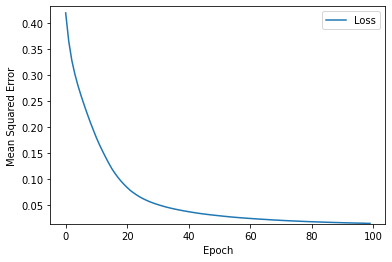

Defined the plot_the_loss_curve function.


In [300]:
plot_the_loss_curve(epochs, mse)

In [301]:
predictions = model.predict(x_train[:10])
for i in range(10):
    print(predictions[i])
    print(y_train[i])

[0.56250304 0.7462276  0.6358173  0.         0.6474911  0.99915594
 0.5892062  0.56027275]
[0.65313189 0.9757633  0.65313189 0.         0.78753541 1.
 0.71671388 0.62228517]
[0.48573166 0.08050445 1.1047118  0.502877   0.38720715 1.0316987
 0.48147285 0.68172616]
[0.52773687 0.         0.92047128 0.60137457 0.52135493 0.86499755
 0.50908198 1.        ]
[0.02801792 0.197655   0.61797655 0.66362786 0.5881069  0.6048393
 0.8897588  0.60019517]
[0.         0.11148272 0.91044221 0.63173541 0.61910071 0.62839093
 1.         0.55406912]
[0.50286967 0.56175154 0.5744456  0.9266162  0.47450566 0.66763747
 0.4313546  0.        ]
[0.69958693 0.69958693 0.78407811 1.         0.61021404 0.93879084
 0.60082614 0.        ]
[0.79084796 0.5061163  0.73106897 0.274364   1.231976   0.93665516
 0.03039084 0.380108  ]
[0.59516779 0.3938255  0.90389262 0.15892617 0.79194631 1.
 0.         0.20134228]
[0.         0.11816159 0.4037368  1.0654367  1.0884458  1.0801872
 0.4418733  0.56685346]
[0.         0.0932

In [302]:
model.save("compatModel.h5")

In [305]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('compatModel.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\leeji\AppData\Local\Temp\tmpd0eq2hgv\assets
